<a href="https://colab.research.google.com/github/LoniQin/deep_learning_notebooks/blob/master/mxnet/DCGAN_Pockermon_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing Packages


In [2]:
!pip install d2l==0.16.2
!pip install -U mxnet-cu101==1.7.0


     |████████████████████████████████| 81kB 5.6MB/s 
     |███████████████████████████████▌| 834.1MB 1.4MB/s eta 0:00:09tcmalloc: large alloc 1147494400 bytes == 0x55705335c000 @  0x7f2f52cf7615 0x5570192cd06c 0x5570193aceba 0x5570192cfe8d 0x5570193c199d 0x557019343fe9 0x55701933eb0e 0x5570192d177a 0x557019343e50 0x55701933eb0e 0x5570192d177a 0x55701934086a 0x5570193c27c6 0x55701933fee2 0x5570193c27c6 0x55701933fee2 0x5570193c27c6 0x55701933fee2 0x5570193c27c6 0x55701933fee2 0x5570192d169a 0x55701933fc9e 0x55701933ee0d 0x5570192d177a 0x55701933fa45 0x5570192d169a 0x55701933fa45 0x55701933eb0e 0x5570192d177a 0x55701934086a 0x55701933eb0e
     |████████████████████████████████| 846.0MB 21kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


## Importing Packages

In [3]:
from mxnet import gluon, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

## The Pokemon Dataset

Now we download [pokemondb](https://pokemondb.net/sprites) dataset, a collection of Pokemon sprites.


In [4]:
#@save
d2l.DATA_HUB['pokemon'] = (d2l.DATA_URL + 'pokemon.zip',
                           'c065c0e2593b8b161a2d7873e42418bf6a21106c')

data_dir = d2l.download_extract('pokemon')
pokemon = gluon.data.vision.datasets.ImageFolderDataset(data_dir)

We resize each image into $64\times 64$. The `ToTensor` transformation will project the pixel value into $[0, 1]$, while our generator will use the tanh function to obtain outputs in $[-1, 1]$. Therefore we normalize the data with $0.5$ mean and $0.5$ standard deviation to match the value range.


In [5]:
batch_size = 256
transformer = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.Resize(64),
    gluon.data.vision.transforms.ToTensor(),
    gluon.data.vision.transforms.Normalize(0.5, 0.5)])
data_iter = gluon.data.DataLoader(pokemon.transform_first(transformer),
                                  batch_size=batch_size, shuffle=True,
                                  num_workers=d2l.get_dataloader_workers())

## Ploting images

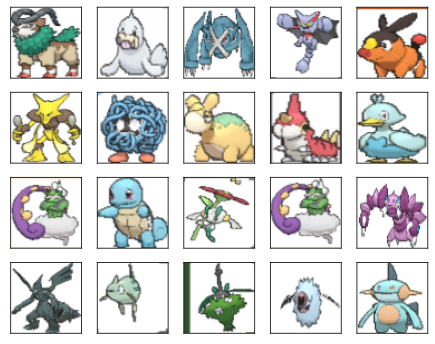

In [6]:
d2l.set_figsize((4, 4))
for X, y in data_iter:
    imgs = X[0:20, :, :, :].transpose(0, 2, 3, 1) / 2 + 0.5
    d2l.show_images(imgs, num_rows=4, num_cols=5)
    break

## Building The Generator

In [28]:
class GeneratorBlock(nn.Block):
    def __init__(self, channels, kernel_size=4, strides=2, padding=1,
                 **kwargs):
        super(GeneratorBlock, self).__init__(**kwargs)
        self.conv2d_trans = nn.Conv2DTranspose(channels, kernel_size, strides,
                                               padding, use_bias=False)
        self.batch_norm = nn.BatchNorm()
        self.activation = nn.Activation('relu')

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

In [48]:
image_width = 64
generator = nn.Sequential()
generator.add(GeneratorBlock(image_width * 8, strides=1, padding=0),  # Output: (64 * 8, 4, 4)
          GeneratorBlock(image_width * 4),  # Output: (64 * 4, 8, 8)
          GeneratorBlock(image_width * 2),  # Output: (64 * 2, 16, 16)
          GeneratorBlock(image_width),  # Output: (64, 32, 32)
          nn.Conv2DTranspose(3, kernel_size=4, strides=2, padding=1,
                             use_bias=False,
                             activation='tanh'))  # Output: (3, 64, 64)

Generate a 100 dimensional latent variable to verify the generator's output shape.


In [49]:
x = np.zeros((1, 100, 1, 1))
generator.initialize()
generator(x).shape

(1, 3, 64, 64)

## Building the Discriminator


The basic block of the discriminator is a convolution layer followed by a batch normalization layer and a leaky ReLU activation. The hyperparameters of the convolution layer are similar to the transpose convolution layer in the generator block.


In [52]:
class Discriminatorblock(nn.Block):
    def __init__(self, channels, kernel_size=4, strides=2, padding=1,
                 alpha=0.2, **kwargs):
        super(Discriminatorblock, self).__init__(**kwargs)
        self.conv2d = nn.Conv2D(channels, kernel_size, strides, padding,
                                use_bias=False)
        self.batch_norm = nn.BatchNorm()
        self.activation = nn.LeakyReLU(alpha)

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))

The discriminator is a mirror of the generator.


In [54]:
discriminator = nn.Sequential()
discriminator.add(Discriminatorblock(image_width),  # Output: (64, 32, 32)
          Discriminatorblock(image_width * 2),  # Output: (64 * 2, 16, 16)
          Discriminatorblock(image_width * 4),  # Output: (64 * 4, 8, 8)
          Discriminatorblock(image_width * 8),  # Output: (64 * 8, 4, 4)
          nn.Conv2D(1, kernel_size=4, use_bias=False))  # Output: (1, 1, 1)

It uses a convolution layer with output channel $1$ as the last layer to obtain a single prediction value.


In [55]:
x = np.zeros((1, 3, 64, 64))
discriminator.initialize()
discriminator(x).shape

(1, 1, 1, 1)

## Training the Model

In [57]:
def train(discriminator, generator, data_iter, num_epochs, lr, latent_dim,
          device=d2l.try_gpu()):
    loss = gluon.loss.SigmoidBCELoss()
    discriminator.initialize(init=init.Normal(0.02), force_reinit=True, ctx=device)
    generator.initialize(init=init.Normal(0.02), force_reinit=True, ctx=device)
    trainer_hp = {'learning_rate': lr, 'beta1': 0.5}
    discriminator_trainer = gluon.Trainer(discriminator.collect_params(), 'adam', trainer_hp)
    generator_trainer = gluon.Trainer(generator.collect_params(), 'adam', trainer_hp)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(1, num_epochs + 1):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = np.random.normal(0, 1, size=(batch_size, latent_dim, 1, 1))
            X, Z = X.as_in_ctx(device), Z.as_in_ctx(device),
            metric.add(d2l.update_D(X, Z, discriminator, generator, loss, discriminator_trainer),
                       d2l.update_G(Z, discriminator, generator, loss, generator_trainer),
                       batch_size)
        # Show generated examples
        Z = np.random.normal(0, 1, size=(21, latent_dim, 1, 1), ctx=device)
        # Normalize the synthetic data to N(0, 1)
        fake_x = generator(Z).transpose(0, 2, 3, 1) / 2 + 0.5
        imgs = np.concatenate([
            np.concatenate([fake_x[i * 7 + j] for j in range(7)], axis=1)
            for i in range(len(fake_x) // 7)], axis=0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs.asnumpy())
        # Show the losses
        discriminator_loss, generator_loss = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (discriminator_loss, generator_loss))
    print(f'Discriminator Loss: {discriminator_loss:.3f}, Generactor Loss: {generator_loss:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device)}')

We train the model with a small number of epochs just for demonstration.
For better performance,
the variable `num_epochs` can be set to a larger number.


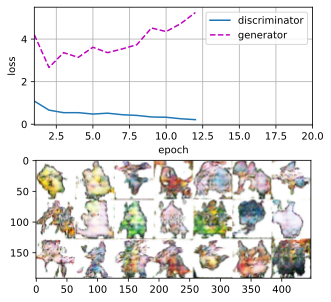

In [ ]:
latent_dim, lr, num_epochs = 100, 0.005, 20
train(discriminator, generator, data_iter, num_epochs, lr, latent_dim)

## Conclusion
Wow! This Pockermon looks so great!